# PrithviWxC Rollout Inference
If you haven't already, take a look at the exmaple for the PrithviWxC core
model, as we will pass over the points covered there.

Here we will introduce the PrithviWxC model that was trained furhter for
autoregressive rollout, a common strategy to increase accuracy and stability of
models when applied to forecasting-type tasks. 

In [1]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from huggingface_hub import hf_hub_download, snapshot_download
import yaml

/home/simon/miniconda3/envs/fm4a/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


*Note:* For this hands on, we will leverage smaller version of the Prithvi-WxC model (600m Parameter size). Original size of the model is 2300m. If interested, config files are provided. The following boolean `use_small_model` can be set to False for large model use.

In [2]:
use_small_model = True

In [3]:
"""
This cell helps setup the basic things such as the seeds, device, variables used throughout the notebook.
"""

# Set backend etc.
torch.jit.enable_onednn_fusion(True)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

# Set seeds
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.manual_seed(42)
np.random.seed(42)

# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Set variables
surface_vars = [
    "EFLUX",
    "GWETROOT",
    "HFLUX",
    "LAI",
    "LWGAB",
    "LWGEM",
    "LWTUP",
    "PS",
    "QV2M",
    "SLP",
    "SWGNT",
    "SWTNT",
    "T2M",
    "TQI",
    "TQL",
    "TQV",
    "TS",
    "U10M",
    "V10M",
    "Z0M",
]
static_surface_vars = ["FRACI", "FRLAND", "FROCEAN", "PHIS"]
vertical_vars = ["CLOUD", "H", "OMEGA", "PL", "QI", "QL", "QV", "T", "U", "V"]
levels = [
    34.0,
    39.0,
    41.0,
    43.0,
    44.0,
    45.0,
    48.0,
    51.0,
    53.0,
    56.0,
    63.0,
    68.0,
    71.0,
    72.0,
]
padding = {"level": [0, 0], "lat": [0, -1], "lon": [0, 0]}

variable_names = surface_vars + [
    f'{var}_level_{level}' for var in vertical_vars for level in levels
]

### Lead time
When performing auto-regressive rollout, the intermediate steps require the
static data at those times and---if using `residual=climate`---the intermediate
climatology. We provide a dataloader that extends the MERRA2 loader of the
core model, adding in these additional terms. Further, it return target data for
the intermediate steps if those are required for loss terms. 

The `lead_time` flag still lets the target time for the model, however now it
only a single value and must be a positive integer multiple of the `-input_time`. 

In [4]:
lead_time = 12  # This variable can be change to change the task
input_time = -6  # This variable can be change to change the task

### Data file
MERRA-2 data is available from 1980 to the present day,
at 3-hour temporal resolution. The dataloader we have provided
expects the surface data and vertical data to be saved in
separate files, and when provided with the directories, will
search for the relevant data that falls within the provided time range.


In [15]:
time_range = ("2020-01-01T00:00:00", "2020-01-01T23:59:59")

data_path = "../data/"
surf_dir = Path(f"{data_path}merra-2")
snapshot_download(
    repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M",
    allow_patterns="merra-2/MERRA2_sfc_2020010[1].nc",
    local_dir=data_path,
)

vert_dir = surf_dir
snapshot_download(
    repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M",
    allow_patterns="merra-2/MERRA_pres_2020010[1].nc",
    local_dir=data_path,
)

Fetching 1 files: 100%|███████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


'/home/simon/src/fm4a/data'

### Climatology
The PrithviWxC model was trained to calculate the output by
producing a perturbation to the climatology at the target time.
 This mode of operation is set via the `residual=climate` option.
 This was chosen as climatology is typically a strong prior for
 long-range prediction. When using the `residual=climate` option,
 we have to provide the dataloader with the path of the
 climatology data.

In [16]:
surf_clim_dir = Path(f"{data_path}climatology")
snapshot_download(
    repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M",
    allow_patterns="climatology/climate_surface_doy00[1]*.nc",
    local_dir=data_path,
)

vert_clim_dir = surf_clim_dir
snapshot_download(
    repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M",
    allow_patterns="climatology/climate_vertical_doy00[1]*.nc",
    local_dir=data_path,
)

Fetching 8 files: 100%|███████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.84it/s]


'/home/simon/src/fm4a/data'

In [17]:
positional_encoding = "fourier"

### Dataloader init
We are now ready to instantiate the dataloader.

In [18]:
from PrithviWxC.dataloaders.merra2_rollout import Merra2RolloutDataset

dataset = Merra2RolloutDataset(
    time_range=time_range,
    lead_time=lead_time,
    input_time=input_time,
    data_path_surface=surf_dir,
    data_path_vertical=vert_dir,
    climatology_path_surface=surf_clim_dir,
    climatology_path_vertical=vert_clim_dir,
    surface_vars=surface_vars,
    static_surface_vars=static_surface_vars,
    vertical_vars=vertical_vars,
    levels=levels,
    positional_encoding=positional_encoding,
)
assert len(dataset) > 0, "There doesn't seem to be any valid data."

## Model
### Scalers and other hyperparameters
Again, this setup is similar as before.

In [19]:
from PrithviWxC.dataloaders.merra2 import (
    input_scalers,
    output_scalers,
    static_input_scalers,
)

surf_in_scal_path = Path(f"{surf_clim_dir}/musigma_surface.nc")
hf_hub_download(
    repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M",
    filename=f"climatology/{surf_in_scal_path.name}",
    local_dir=data_path,
)

vert_in_scal_path = Path(f"{surf_clim_dir}/musigma_vertical.nc")
hf_hub_download(
    repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M",
    filename=f"climatology/{vert_in_scal_path.name}",
    local_dir=data_path,
)

surf_out_scal_path = Path(f"{surf_clim_dir}/anomaly_variance_surface.nc")
hf_hub_download(
    repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M",
    filename=f"climatology/{surf_out_scal_path.name}",
    local_dir=data_path,
)

vert_out_scal_path = Path(f"{surf_clim_dir}/anomaly_variance_vertical.nc")
hf_hub_download(
    repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M",
    filename=f"climatology/{vert_out_scal_path.name}",
    local_dir=data_path,
)

hf_hub_download(
    repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M-rollout",
    filename="config.yaml",
    local_dir=data_path,
)

in_mu, in_sig = input_scalers(
    surface_vars,
    vertical_vars,
    levels,
    surf_in_scal_path,
    vert_in_scal_path,
)

output_sig = output_scalers(
    surface_vars,
    vertical_vars,
    levels,
    surf_out_scal_path,
    vert_out_scal_path,
)

static_mu, static_sig = static_input_scalers(
    surf_in_scal_path,
    static_surface_vars,
)

residual = "climate"
masking_mode = "both"
encoder_shifting = True
decoder_shifting = True
masking_ratio = 0.0

### Model init
We can now build and load the pretrained weights, note that you should use the
rollout version of the weights.

In [20]:
model_name = "prithvi.wxc.rollout.2300m.v1.pt"

weights_path = Path(f"{data_path}weights/{model_name}")

if use_small_model:
    model_name = "prithvi.wxc.rollout.600m.v1.pt"
    weights_path = Path(f"{data_path}weights/{model_name}") 
else:
    hf_hub_download(
    repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M-rollout",
    filename=weights_path.name,
    local_dir=f"{data_path}weights",
)

In [21]:
import yaml

# PrithviWxC installed from https://github.com/NASA-IMPACT/Prithvi-WxC
from PrithviWxC.model import PrithviWxC

config_filename = "config.yaml"

if use_small_model:
    config_filename = "config_small.yaml"
    
with open(f"../configs/{config_filename}", "r") as f:
    config = yaml.safe_load(f)

model = PrithviWxC(
    in_channels=config["params"]["in_channels"],
    input_size_time=config["params"]["input_size_time"],
    in_channels_static=config["params"]["in_channels_static"],
    input_scalers_mu=in_mu,
    input_scalers_sigma=in_sig,
    input_scalers_epsilon=config["params"]["input_scalers_epsilon"],
    static_input_scalers_mu=static_mu,
    static_input_scalers_sigma=static_sig,
    static_input_scalers_epsilon=config["params"][
        "static_input_scalers_epsilon"
    ],
    output_scalers=output_sig**0.5,
    n_lats_px=config["params"]["n_lats_px"],
    n_lons_px=config["params"]["n_lons_px"],
    patch_size_px=config["params"]["patch_size_px"],
    mask_unit_size_px=config["params"]["mask_unit_size_px"],
    mask_ratio_inputs=masking_ratio,
    mask_ratio_targets=0.0,
    embed_dim=config["params"]["embed_dim"],
    n_blocks_encoder=config["params"]["n_blocks_encoder"],
    n_blocks_decoder=config["params"]["n_blocks_decoder"],
    mlp_multiplier=config["params"]["mlp_multiplier"],
    n_heads=config["params"]["n_heads"],
    dropout=config["params"]["dropout"],
    drop_path=config["params"]["drop_path"],
    parameter_dropout=config["params"]["parameter_dropout"],
    residual=residual,
    masking_mode=masking_mode,
    encoder_shifting=encoder_shifting,
    decoder_shifting=decoder_shifting,
    positional_encoding=positional_encoding,
    checkpoint_encoder=[],
    checkpoint_decoder=[],
)


state_dict = torch.load(weights_path, weights_only=False)
if "model_state" in state_dict:
    state_dict = state_dict["model_state"]
model.load_state_dict(state_dict, strict=True)

if (hasattr(model, "device") and model.device != device) or not hasattr(
    model, "device"
):
    model = model.to(device)

## Rollout
We are now ready to perform the rollout. Agin the data has to be run through a
preprocessor. However this time we use a preprocessor that can handle the
additional intermediate data. Also, rather than calling the model directly, we
have a conveient wrapper function that performs the interation. This also
simplifies the model loading when using a sharded cahckpoint. If you attempt to
perform training steps upton this function, we should use an aggressive number
of activation checkpoints as the memory consumption becomes quite high.

In [22]:
from PrithviWxC.dataloaders.merra2_rollout import preproc
from PrithviWxC.rollout import rollout_iter

data = next(iter(dataset))
batch = preproc([data], padding)

for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.to(device)

rng_state_1 = torch.get_rng_state()
with torch.no_grad():
    model.eval()
    out = rollout_iter(dataset.nsteps, model, batch)

## Plotting

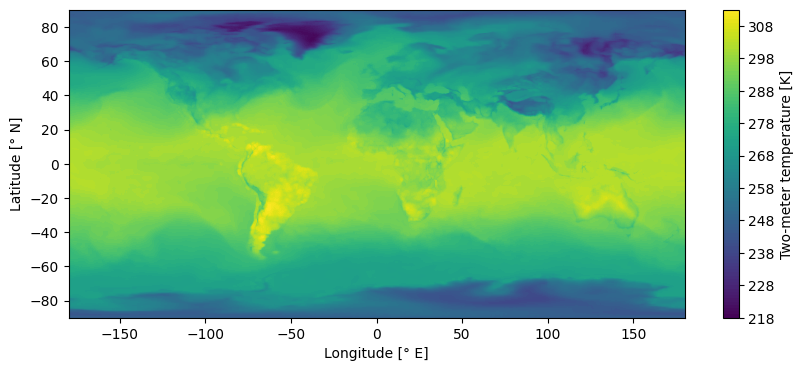

In [23]:
t2m = out[0, variable_names.index("T2M")].cpu().numpy()

lat = np.linspace(-90, 90, out.shape[-2])
lon = np.linspace(-180, 180, out.shape[-1])
X, Y = np.meshgrid(lon, lat)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
m = ax.contourf(X, Y, t2m, 100)
ax.set_aspect("equal")
ax.set_xlabel("Longitude [° E]")
ax.set_ylabel("Latitude [° N]")
plt.colorbar(m, label="Two-meter temperature [K]")
plt.show()

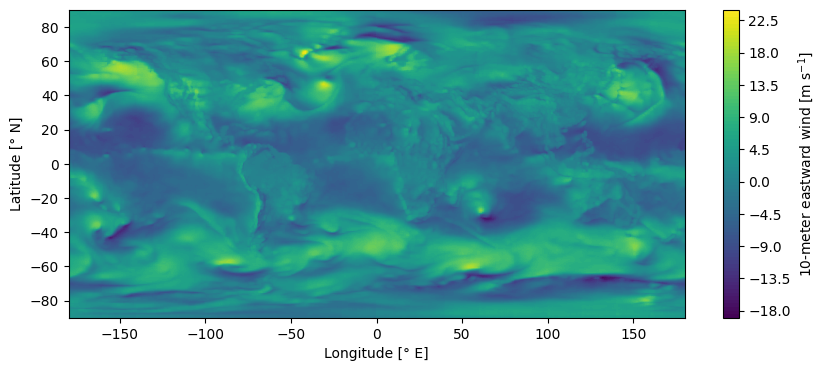

In [24]:
u10m = out[0, variable_names.index("U10M")].cpu().numpy()

lat = np.linspace(-90, 90, out.shape[-2])
lon = np.linspace(-180, 180, out.shape[-1])
X, Y = np.meshgrid(lon, lat)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
m = ax.contourf(X, Y, u10m, 100)
ax.set_aspect("equal")
ax.set_xlabel("Longitude [° E]")
ax.set_ylabel("Latitude [° N]")
plt.colorbar(m, label="10-meter eastward wind [m s$^{-1}$]")
plt.show()